# RGB-D End-to-End Pipeline for 6D Pose Estimation

This notebook demonstrates the complete **YOLO → RGB-D Fusion** pipeline for 6D object pose estimation on the LineMOD dataset.

## Architecture Overview

**Output:** 7-dim pose vector `[qw, qx, qy, qz, tx, ty, tz]`
- Quaternion (4D): rotation as unit quaternion
- Translation (3D): object position in camera frame (meters)

**Reference:** Inspired by *DenseFusion: 6D Object Pose Estimation by Iterative Dense Fusion* (Wang et al.)

## 1. Setup and Imports

In [3]:
import sys
from pathlib import Path

IMG_EXPORT_REL = "./figures/rgbd_e2e_pipeline/"

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
from scipy.spatial.transform import Rotation as R_scipy

# Project imports
from config import Config
from models.yolo_detector import YOLODetector
from models.pose_estimator_RGBD import RGBDFusionModel, build_crop_meta
from dataset.linemod_pose import LineMODPoseDataset
from utils.metrics import compute_add_batch_full_pose
from utils.file_io import load_all_models, load_models_info
from utils.transforms import quaternion_to_rotation_matrix_batch

# Set matplotlib style for paper-quality figures
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11

print(f"Imports completed")
print(f"   Device: {Config.DEVICE}")
print(f"   PyTorch: {torch.__version__}")

Imports completed
   Device: mps
   PyTorch: 2.9.1


## 2. Load Pre-trained Models

Load the fine-tuned **YOLO11** detector and **RGB-D Fusion** pose estimator.

In [4]:
# ============================================================================
# 2.1 Load YOLO Detector
# ============================================================================
yolo_ckpt = Config.CHECKPOINT_DIR / 'yolo' / 'yolo_train10' / 'weights' / 'best.pt'

if yolo_ckpt.exists():
    yolo_detector = YOLODetector(
        model_name=str(yolo_ckpt),
        num_classes=Config.NUM_CLASSES
    )
    print(f"YOLO loaded from: {yolo_ckpt}")
else:
    raise FileNotFoundError(f"YOLO checkpoint not found: {yolo_ckpt}")

Loading custom weights: /Users/ale/Documents/polito/AML/polito-aml-6D-pose-estimation/checkpoints/yolo/yolo_train10/weights/best.pt
YOLO loaded from: /Users/ale/Documents/polito/AML/polito-aml-6D-pose-estimation/checkpoints/yolo/yolo_train10/weights/best.pt


In [5]:
# ============================================================================
# 2.2 Load RGB-D Fusion Model
# ============================================================================
rgbd_ckpt = Config.CHECKPOINT_DIR / 'pose' / 'fusion_rgbd_512' / 'best.pt'

# Initialize model architecture
rgbd_model = RGBDFusionModel(
    rgb_output_dim=512,
    depth_output_dim=512,
    meta_output_dim=32,
    meta_input_dim=10,
    pose_dropout=0.3,
    pretrained_rgb=False  # We'll load trained weights
).to(Config.DEVICE)

# Load trained weights
if rgbd_ckpt.exists():
    checkpoint = rgbd_model.load_weights(rgbd_ckpt, device=Config.DEVICE)
    print(f"RGB-D Fusion Model loaded from: {rgbd_ckpt}")
    print(f"   Epoch: {checkpoint.get('epoch', 'N/A')}")
    print(f"   Val Loss: {checkpoint.get('val_loss', 'N/A'):.4f}" if 'val_loss' in checkpoint else "")
else:
    raise FileNotFoundError(f"RGB-D checkpoint not found: {rgbd_ckpt}")

# Set to eval mode
rgbd_model.eval()

# Print model info
params = rgbd_model.count_parameters()
print(f"\nModel Parameters: {params['total']:,} total, {params['trainable']:,} trainable")

Weights successfully loaded from: /Users/ale/Documents/polito/AML/polito-aml-6D-pose-estimation/checkpoints/pose/fusion_rgbd_512/best.pt
   Epoch: 45
   Val Loss: 16.6303
RGB-D Fusion Model loaded from: /Users/ale/Documents/polito/AML/polito-aml-6D-pose-estimation/checkpoints/pose/fusion_rgbd_512/best.pt
   Epoch: 44
   Val Loss: 16.6303

Model Parameters: 14,505,255 total, 14,505,255 trainable


In [6]:
# ============================================================================
# 2.3 Load 3D Models and Info (for ADD metric computation)
# ============================================================================
models_info = load_models_info(Config.MODELS_PATH / 'models_info.yml')
models_dict = load_all_models(Config.MODELS_PATH)

print(f"3D models loaded: {len(models_dict)} objects")
print(f"   Symmetric objects: {Config.SYMMETRIC_OBJECTS}")

[load_all_models] VERBOSE - Loading data
[load_all_models] Loaded model 01: 5841 points
[load_all_models] Loaded model 02: 38325 points
[load_all_models] Loaded model 04: 18995 points
[load_all_models] Loaded model 05: 22831 points
[load_all_models] Loaded model 06: 15736 points
[load_all_models] Loaded model 08: 12655 points
[load_all_models] Loaded model 09: 7912 points
[load_all_models] Loaded model 10: 18473 points
[load_all_models] Loaded model 11: 7479 points
[load_all_models] Loaded model 12: 15972 points
[load_all_models] Loaded model 13: 18216 points
[load_all_models] Loaded model 14: 27435 points
[load_all_models] Loaded model 15: 16559 points
3D models loaded: 13 objects
   Symmetric objects: [10, 11]


## 3. Dataset and Preprocessing

We use the same dataset structure from the training phase, with additional utilities for cropping ROIs from YOLO detections.

In [7]:
# ============================================================================
# 3.1 ROI Crop Utility
# ============================================================================
def crop_roi(image: np.ndarray, bbox_xyxy: np.ndarray, margin: float = 0.15, output_size: int = 224):
    """
    Crop a region of interest from an image given a bounding box.
    
    Args:
        image: Input image (H, W, C) for RGB or (H, W) for depth
        bbox_xyxy: Bounding box [x1, y1, x2, y2]
        margin: Margin to add around the bbox (as fraction of bbox size)
        output_size: Output size for the crop (square)
    
    Returns:
        Cropped and resized image
    """
    x1, y1, x2, y2 = bbox_xyxy
    w, h = x2 - x1, y2 - y1
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
    
    # Add margin and make it square
    size = max(w, h) * (1 + margin)
    half = size / 2
    
    # Compute crop coordinates (clipped to image bounds)
    img_h, img_w = image.shape[:2]
    x1_crop = int(max(0, cx - half))
    y1_crop = int(max(0, cy - half))
    x2_crop = int(min(img_w, cx + half))
    y2_crop = int(min(img_h, cy + half))
    
    # Crop
    if image.ndim == 3:
        crop = image[y1_crop:y2_crop, x1_crop:x2_crop, :]
    else:
        crop = image[y1_crop:y2_crop, x1_crop:x2_crop]
    
    # Resize to output size
    interp = cv2.INTER_LINEAR if image.ndim == 3 else cv2.INTER_NEAREST
    crop_resized = cv2.resize(crop, (output_size, output_size), interpolation=interp)
    
    return crop_resized

print("ROI crop utility defined")

ROI crop utility defined


In [8]:
# ============================================================================
# 3.2 Fusion Dataset with YOLO Detection Support
# ============================================================================
class LineMODFusionDataset(Dataset):
    """
    Dataset that returns RGB crop, Depth crop, and pose labels.
    Uses ground truth bboxes during training/evaluation for consistency.
    """
    
    def __init__(self, base_dataset, crop_margin=0.15, output_size=224, depth_max=2000.0):
        self.base_dataset = base_dataset
        self.crop_margin = crop_margin
        self.output_size = output_size
        self.depth_max = depth_max
        self.imagenet_normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        sample = self.base_dataset[idx]
        
        # Load full images
        rgb_full = cv2.cvtColor(cv2.imread(sample['rgb_path']), cv2.COLOR_BGR2RGB)
        depth_full = np.array(Image.open(sample['depth_path']))
        
        # Get bbox (convert from [x,y,w,h] to [x1,y1,x2,y2])
        bbox = sample['bbox'].numpy()
        x, y, w, h = bbox
        bbox_xyxy = np.array([x, y, x+w, y+h])
        
        # Crop both RGB and Depth at same coordinates
        rgb_crop = crop_roi(rgb_full, bbox_xyxy, self.crop_margin, self.output_size)
        depth_crop = crop_roi(depth_full, bbox_xyxy, self.crop_margin, self.output_size)
        
        # Normalize depth to [0, 1]
        depth_crop = np.clip(depth_crop / self.depth_max, 0, 1).astype(np.float32)
        
        # Convert RGB to tensor and normalize
        rgb_tensor = torch.from_numpy(rgb_crop).permute(2, 0, 1).float() / 255.0
        rgb_tensor = self.imagenet_normalize(rgb_tensor)
        
        # Convert depth to tensor
        depth_tensor = torch.from_numpy(depth_crop).unsqueeze(0).float()
        
        # Build metadata for translation disambiguation
        img_h, img_w = rgb_full.shape[:2]
        meta = build_crop_meta(sample['bbox'], sample['cam_K'], img_h, img_w)
        
        return {
            'rgb': rgb_tensor,
            'depth': depth_tensor,
            'quaternion': sample['quaternion'],
            'translation': sample['translation'],
            'obj_id': torch.tensor(sample['obj_id'], dtype=torch.long),
            'meta': meta,
            'rgb_path': sample['rgb_path'],
            'depth_path': sample['depth_path'],
            'bbox': sample['bbox']
        }

print("LineMODFusionDataset defined")

LineMODFusionDataset defined


In [9]:
# ============================================================================
# 3.3 Create Test Dataset and DataLoader
# ============================================================================
# Load test dataset (from LineMODPoseDataset)
test_base = LineMODPoseDataset(
    dataset_root=Config.LINEMOD_ROOT,
    split='test',
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE
)

# Wrap in fusion dataset
test_dataset = LineMODFusionDataset(test_base, crop_margin=0.15, output_size=224)

# Create DataLoader
BATCH_SIZE = 64
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Test dataset created:")
print(f"   Total samples: {len(test_dataset)}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Total batches: {len(test_loader)}")

Test dataset created:
   Total samples: 3213
   Batch size: 64
   Total batches: 51


## 4. Pipeline Demo: YOLO → RGB-D Fusion

Demonstrate the complete end-to-end pipeline on a single sample:

In [10]:
# ============================================================================
# 4.1 Single-Sample Pipeline Demo
# ============================================================================
# Get a sample from test dataset
sample = test_dataset[100]  # Pick a representative sample
rgb_path = sample['rgb_path']
depth_path = sample['depth_path']
gt_bbox = sample['bbox'].numpy()

print(f"📷 Sample image: {rgb_path}")
print(f"📏 GT BBox [x,y,w,h]: {gt_bbox}")

# Load full images
image_bgr = cv2.imread(rgb_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
depth_raw = np.array(Image.open(depth_path))

# ---- STEP 1: YOLO Detection ----
detections = yolo_detector.detect_objects(image_bgr, conf_threshold=0.3)

print(f"\n🎯 YOLO detected {len(detections)} object(s)")
for i, det in enumerate(detections):
    print(f"   [{i+1}] Class: {det['class_name']}, Conf: {det['confidence']:.2f}, BBox: {det['bbox']}")

📷 Sample image: /Users/ale/Documents/polito/AML/polito-aml-6D-pose-estimation/data/Linemod_preprocessed/data/01/rgb/0636.png
📏 GT BBox [x,y,w,h]: [        269         181          52          74]

🎯 YOLO detected 1 object(s)
   [1] Class: ape, Conf: 0.91, BBox: [     269.45       179.9       321.9      253.92]


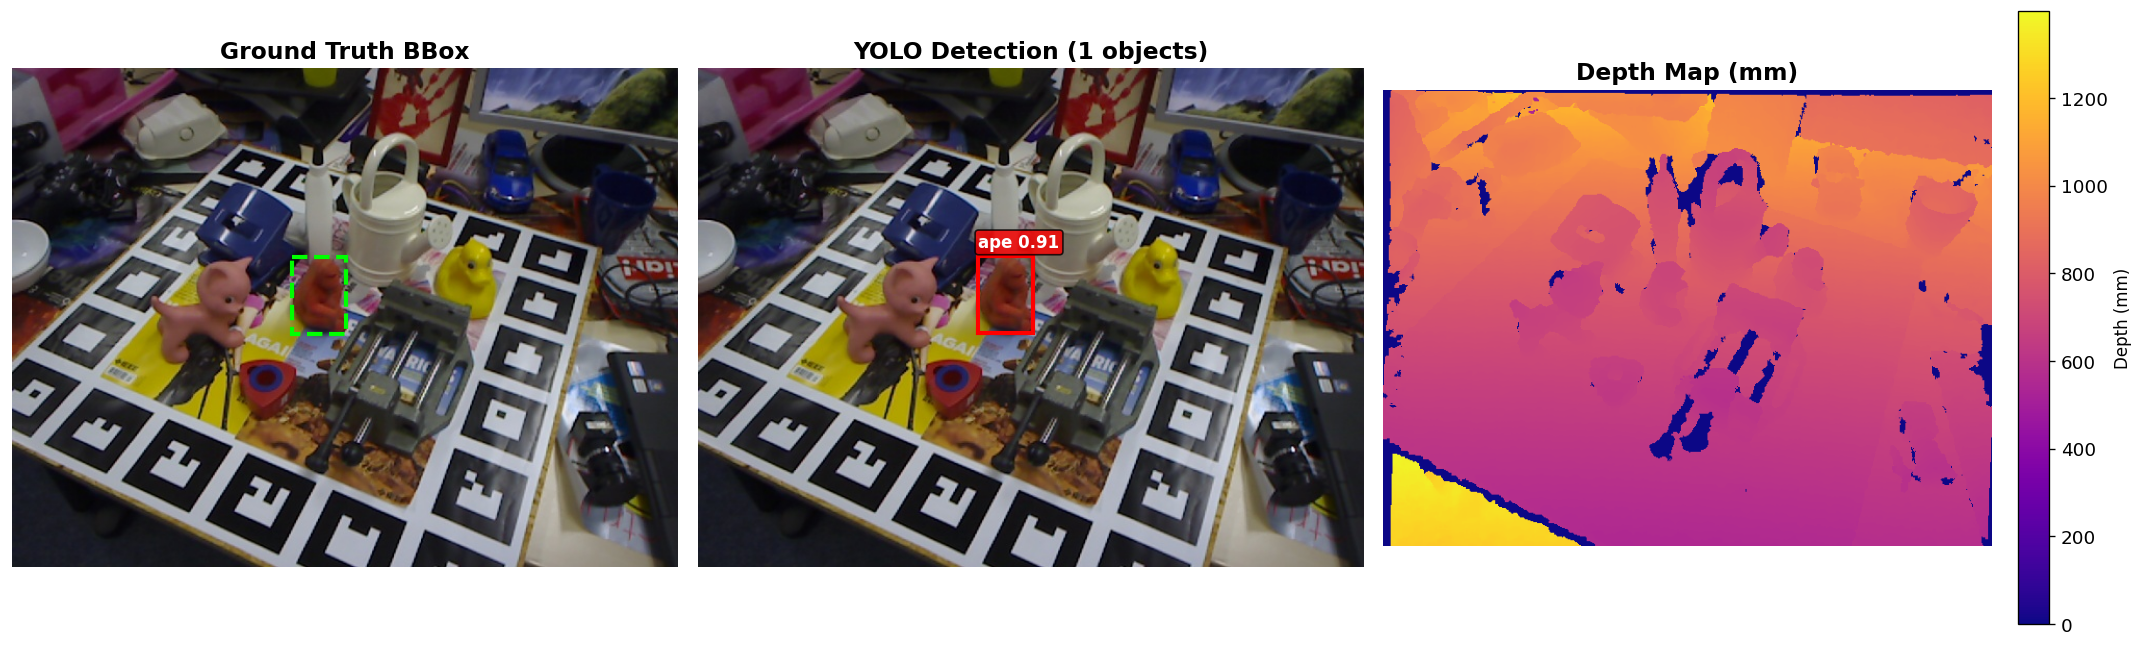


COMPLETED: YOLO object detection


In [11]:
# ============================================================================
# 4.2 Visualize YOLO Detection
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image with GT bbox
axes[0].imshow(image_rgb)
x, y, w, h = gt_bbox
rect_gt = plt.Rectangle((x, y), w, h, fill=False, edgecolor='lime', linewidth=2.5, linestyle='--')
axes[0].add_patch(rect_gt)
axes[0].set_title('Ground Truth BBox', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Image with YOLO detections
axes[1].imshow(image_rgb)
for det in detections:
    x1, y1, x2, y2 = det['bbox']
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2.5)
    axes[1].add_patch(rect)
    axes[1].text(x1, y1-8, f"{det['class_name']} {det['confidence']:.2f}", 
                 color='white', fontsize=10, fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor='red', alpha=0.8))
axes[1].set_title(f'YOLO Detection ({len(detections)} objects)', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Depth visualization
im = axes[2].imshow(depth_raw, cmap='plasma')
axes[2].set_title('Depth Map (mm)', fontsize=14, fontweight='bold')
axes[2].axis('off')
cbar = plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
cbar.set_label('Depth (mm)', fontsize=10)

plt.tight_layout()
plt.savefig(IMG_EXPORT_REL + 'yolo_detection_demo.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nCOMPLETED: YOLO object detection")

🎯 Using YOLO detection: ape (conf: 0.91)


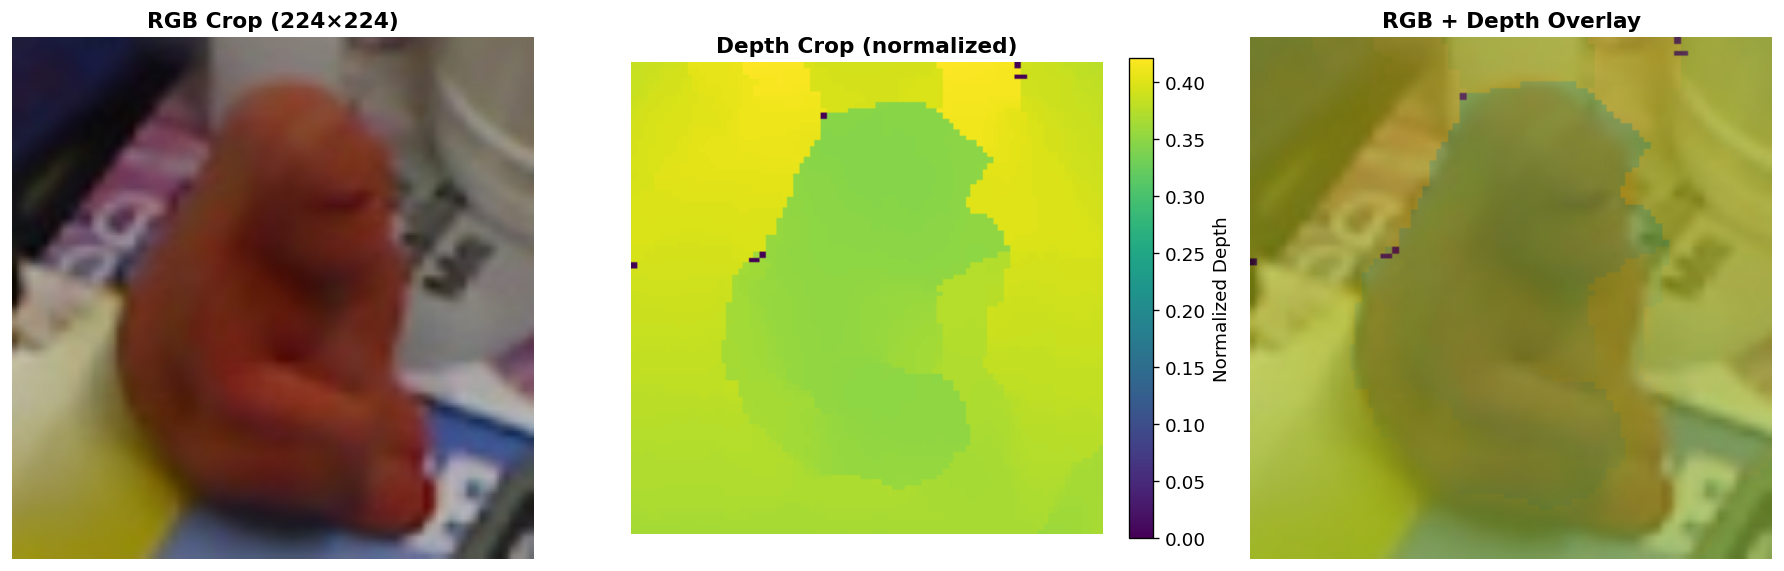


Step 2 complete: ROI cropping


In [12]:
# ============================================================================
# 4.3 ROI Cropping: RGB + Depth
# ============================================================================
# Use YOLO detection bbox (if available) or fallback to GT
if len(detections) > 0:
    det = detections[0]
    bbox_xyxy = det['bbox']
    print(f"🎯 Using YOLO detection: {det['class_name']} (conf: {det['confidence']:.2f})")
else:
    x, y, w, h = gt_bbox
    bbox_xyxy = np.array([x, y, x+w, y+h])
    print(f"⚠️ No YOLO detection, using GT bbox")

# Crop RGB and Depth
rgb_crop = crop_roi(image_rgb, bbox_xyxy, margin=0.15, output_size=224)
depth_crop = crop_roi(depth_raw, bbox_xyxy, margin=0.15, output_size=224)

# Normalize depth
DEPTH_MAX = 2000.0
depth_crop_normalized = np.clip(depth_crop / DEPTH_MAX, 0, 1)

# Visualize crops
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(rgb_crop)
axes[0].set_title('RGB Crop (224×224)', fontsize=13, fontweight='bold')
axes[0].axis('off')

im = axes[1].imshow(depth_crop_normalized, cmap='viridis')
axes[1].set_title('Depth Crop (normalized)', fontsize=13, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046, label='Normalized Depth')

axes[2].imshow(rgb_crop)
axes[2].imshow(depth_crop_normalized, cmap='viridis', alpha=0.5)
axes[2].set_title('RGB + Depth Overlay', fontsize=13, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.savefig(IMG_EXPORT_REL + 'roi_crops_demo.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nStep 2 complete: ROI cropping")

In [13]:
# ============================================================================
# 4.4 RGB-D Fusion Pose Estimation
# ============================================================================
# Prepare tensors for the model
imagenet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# RGB tensor
rgb_tensor = torch.from_numpy(rgb_crop).permute(2, 0, 1).float() / 255.0
rgb_tensor = imagenet_normalize(rgb_tensor).unsqueeze(0).to(Config.DEVICE)

# Depth tensor
depth_tensor = torch.from_numpy(depth_crop_normalized).float().unsqueeze(0).unsqueeze(0).to(Config.DEVICE)

# Build metadata (using GT bbox for demo - in real pipeline use YOLO bbox)
img_h, img_w = image_rgb.shape[:2]
meta = build_crop_meta(sample['bbox'], sample['meta'][:9].view(3, 3) if sample['meta'].numel() >= 9 else torch.eye(3), img_h, img_w)
meta = sample['meta'].unsqueeze(0).to(Config.DEVICE)  # Use pre-computed meta from dataset

# Run inference
with torch.no_grad():
    pose_pred = rgbd_model(rgb_tensor, depth_tensor, meta)

pred_quat = pose_pred[0, :4].cpu().numpy()
pred_trans = pose_pred[0, 4:].cpu().numpy()

# Ground truth
gt_quat = sample['quaternion'].numpy()
gt_trans = sample['translation'].numpy()

print(f"✅ Step 3 complete: RGB-D Fusion Pose Estimation")
print(f"\n📊 Prediction vs Ground Truth:")
print(f"   Quaternion [qw,qx,qy,qz]:")
print(f"      Pred: [{pred_quat[0]:+.4f}, {pred_quat[1]:+.4f}, {pred_quat[2]:+.4f}, {pred_quat[3]:+.4f}]")
print(f"      GT:   [{gt_quat[0]:+.4f}, {gt_quat[1]:+.4f}, {gt_quat[2]:+.4f}, {gt_quat[3]:+.4f}]")
print(f"   Translation [tx,ty,tz] (m):")
print(f"      Pred: [{pred_trans[0]:+.4f}, {pred_trans[1]:+.4f}, {pred_trans[2]:+.4f}]")
print(f"      GT:   [{gt_trans[0]:+.4f}, {gt_trans[1]:+.4f}, {gt_trans[2]:+.4f}]")

✅ Step 3 complete: RGB-D Fusion Pose Estimation

📊 Prediction vs Ground Truth:
   Quaternion [qw,qx,qy,qz]:
      Pred: [+0.3438, +0.9170, +0.1863, -0.0791]
      GT:   [+0.3554, +0.9119, +0.1981, -0.0547]
   Translation [tx,ty,tz] (m):
      Pred: [-0.0413, -0.0277, +0.6962]
      GT:   [-0.0339, -0.0363, +0.7203]


## 5. Full Test Set Evaluation with YOLO Detection

Run the complete **YOLO → RGB-D Fusion** pipeline on the entire test set:
1. **YOLO Detection**: For each image, detect objects and get bounding boxes
2. **ROI Cropping**: Crop RGB and Depth using YOLO bboxes (not GT bboxes!)
3. **RGB-D Pose Estimation**: Predict pose from cropped regions
4. **ADD Metric Computation**: Compare predictions with ground truth poses

In [14]:
# ============================================================================
# 5.1 Full YOLO → RGB-D Pipeline Evaluation
# ============================================================================
# This is the TRUE end-to-end pipeline:
# YOLO detection → ROI crop → RGB-D Fusion → Pose estimation

# Storage for results
all_pred_R = []
all_pred_t = []
all_gt_R = []
all_gt_t = []
all_obj_ids = []
all_original_indices = []  # Track original dataset indices
all_rgb_crops = []         # Store crops for visualization
all_depth_crops = []       # Store depth crops for visualization
all_yolo_bboxes = []       # Store YOLO bboxes

# Statistics
yolo_detections_count = 0
yolo_misses_count = 0
samples_evaluated = 0

# ImageNet normalization
imagenet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
DEPTH_MAX = 2000.0

print(f"🔍 Running FULL YOLO → RGB-D Pipeline on test set ({len(test_base)} samples)...")
print(f"   ⚠️  Using YOLO detections, NOT ground truth bboxes!")

with torch.no_grad():
    for idx in tqdm(range(len(test_base)), desc="YOLO → Pose Pipeline"):
        # Get sample from base dataset (has GT pose, camera info, paths)
        sample = test_base[idx]
        
        # Load full images
        rgb_path = sample['rgb_path']
        depth_path = sample['depth_path']
        image_bgr = cv2.imread(rgb_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        depth_raw = np.array(Image.open(depth_path))
        
        # ================================================================
        # STEP 1: YOLO Object Detection
        # ================================================================
        detections = yolo_detector.detect_objects(image_bgr, conf_threshold=0.3)
        
        if len(detections) == 0:
            # No detection - skip this sample
            yolo_misses_count += 1
            continue
        
        yolo_detections_count += 1
        
        # Use best detection (highest confidence)
        det = max(detections, key=lambda x: x['confidence'])
        bbox_xyxy = det['bbox']  # [x1, y1, x2, y2] from YOLO
        
        # ================================================================
        # STEP 2: ROI Cropping (using YOLO bbox!)
        # ================================================================
        rgb_crop = crop_roi(image_rgb, bbox_xyxy, margin=0.15, output_size=224)
        depth_crop = crop_roi(depth_raw, bbox_xyxy, margin=0.15, output_size=224)
        
        # Normalize
        depth_crop_norm = np.clip(depth_crop / DEPTH_MAX, 0, 1).astype(np.float32)
        
        # Convert to tensors
        rgb_tensor = torch.from_numpy(rgb_crop).permute(2, 0, 1).float() / 255.0
        rgb_tensor = imagenet_normalize(rgb_tensor).unsqueeze(0).to(Config.DEVICE)
        depth_tensor = torch.from_numpy(depth_crop_norm).unsqueeze(0).unsqueeze(0).float().to(Config.DEVICE)
        
        # Build meta from YOLO bbox (convert xyxy to xywh)
        x1, y1, x2, y2 = bbox_xyxy
        yolo_bbox_xywh = torch.tensor([x1, y1, x2-x1, y2-y1], dtype=torch.float32)
        img_h, img_w = image_rgb.shape[:2]
        meta = build_crop_meta(yolo_bbox_xywh, sample['cam_K'], img_h, img_w)
        meta = meta.unsqueeze(0).to(Config.DEVICE)
        
        # ================================================================
        # STEP 3: RGB-D Fusion Pose Estimation
        # ================================================================
        pose_pred = rgbd_model(rgb_tensor, depth_tensor, meta)
        
        pred_quat = pose_pred[0, :4]
        pred_trans = pose_pred[0, 4:]
        
        # Convert to rotation matrix
        pred_R = quaternion_to_rotation_matrix_batch(pred_quat.unsqueeze(0).cpu())
        
        # ================================================================
        # STEP 4: Store results with GT
        # ================================================================
        gt_quat = sample['quaternion']
        gt_trans = sample['translation']
        gt_R = quaternion_to_rotation_matrix_batch(gt_quat.unsqueeze(0))
        
        all_pred_R.append(pred_R.to(Config.DEVICE))
        all_pred_t.append(pred_trans.unsqueeze(0))
        all_gt_R.append(gt_R.to(Config.DEVICE))
        all_gt_t.append(gt_trans.unsqueeze(0).to(Config.DEVICE))
        all_obj_ids.append(sample['obj_id'])
        all_original_indices.append(idx)
        
        # Store crops for visualization (keep in memory for small test sets)
        all_rgb_crops.append(rgb_crop)
        all_depth_crops.append(depth_crop_norm)
        all_yolo_bboxes.append(bbox_xyxy)
        
        samples_evaluated += 1

# Concatenate all results
all_pred_R = torch.cat(all_pred_R, dim=0)  # (N, 3, 3)
all_pred_t = torch.cat(all_pred_t, dim=0)  # (N, 3)
all_gt_R = torch.cat(all_gt_R, dim=0)      # (N, 3, 3)
all_gt_t = torch.cat(all_gt_t, dim=0)      # (N, 3)

print(f"\n✅ YOLO → RGB-D Pipeline complete!")
print(f"   Total test samples: {len(test_base)}")
print(f"   YOLO detections: {yolo_detections_count} ({100*yolo_detections_count/len(test_base):.1f}%)")
print(f"   YOLO misses: {yolo_misses_count} ({100*yolo_misses_count/len(test_base):.1f}%)")
print(f"   Samples evaluated: {samples_evaluated}")

🔍 Running FULL YOLO → RGB-D Pipeline on test set (3213 samples)...
   ⚠️  Using YOLO detections, NOT ground truth bboxes!


YOLO → Pose Pipeline: 100%|██████████| 3213/3213 [01:51<00:00, 28.90it/s]



✅ YOLO → RGB-D Pipeline complete!
   Total test samples: 3213
   YOLO detections: 3207 (99.8%)
   YOLO misses: 6 (0.2%)
   Samples evaluated: 3207


In [ ]:
# ============================================================================
# 5.2 Compute ADD Metrics (on YOLO-detected samples)
# ============================================================================
print("Computing ADD metrics on YOLO → RGB-D pipeline results...")

results = compute_add_batch_full_pose(
    pred_R_batch=all_pred_R,
    pred_t_batch=all_pred_t,
    gt_R_batch=all_gt_R,
    gt_t_batch=all_gt_t,
    obj_ids=all_obj_ids,
    models_dict=models_dict,
    models_info=models_info,
    symmetric_objects=Config.SYMMETRIC_OBJECTS,
    threshold=Config.ADD_THRESHOLD
)

# Print overall metrics
print(f"\n{'='*70}")
print(f"{'YOLO → RGB-D FUSION PIPELINE - TEST RESULTS':^70}")
print(f"{'='*70}")
print(f"   YOLO Detection Rate: {100*yolo_detections_count/len(test_base):.2f}%")
print(f"   Mean ADD: {results['mean_add']:.2f} mm")
print(f"   Accuracy: {results['accuracy']*100:.2f}% (< {Config.ADD_THRESHOLD*100:.0f}% diameter)")
print(f"   Evaluated samples: {len(results['add_values'])} / {len(test_base)}")
print(f"{'='*70}")

# Also compute "effective accuracy" considering YOLO misses as failures
effective_correct = sum(results['is_correct'])
effective_total = len(test_base)
effective_accuracy = effective_correct / effective_total * 100

print(f"\nEffective Accuracy (including YOLO misses as failures):")
print(f"   {effective_correct} / {effective_total} = {effective_accuracy:.2f}%")

📊 Computing ADD metrics on YOLO → RGB-D pipeline results...

             YOLO → RGB-D FUSION PIPELINE - TEST RESULTS              
   YOLO Detection Rate: 99.81%
   Mean ADD: 8.20 mm
   Accuracy: 95.10% (< 10% diameter)
   Evaluated samples: 3207 / 3213

📊 Effective Accuracy (including YOLO misses as failures):
   3050 / 3213 = 94.93%


## 6. Per-Object Analysis

Breakdown of results by object class for detailed analysis.

In [16]:
# ============================================================================
# 6.1 Per-Object Results Table
# ============================================================================
per_object_results = {}

for obj_id in set(all_obj_ids):
    # Get indices for this object
    indices = [i for i, oid in enumerate(all_obj_ids) if oid == obj_id]
    
    # Extract metrics for this object
    obj_add_values = [results['add_values'][i] for i in indices]
    obj_is_correct = [results['is_correct'][i] for i in indices]
    
    # Get object name from Config
    obj_name = Config.LINEMOD_OBJECTS.get(obj_id, {}).get('name', f'Object {obj_id}')
    
    # Compute statistics
    per_object_results[obj_id] = {
        'Object': obj_name,
        'Count': len(indices),
        'Mean ADD (mm)': np.mean(obj_add_values),
        'Median ADD (mm)': np.median(obj_add_values),
        'Std ADD (mm)': np.std(obj_add_values),
        'Accuracy (%)': np.mean(obj_is_correct) * 100,
        'Diameter (mm)': models_info[obj_id]['diameter'],
        'Symmetric': '✓' if obj_id in Config.SYMMETRIC_OBJECTS else ''
    }

# Create DataFrame
df_results = pd.DataFrame.from_dict(per_object_results, orient='index')
df_results.index.name = 'ID'
df_results = df_results.sort_values('Accuracy (%)', ascending=False)

# Format for display
df_display = df_results.copy()
df_display['Mean ADD (mm)'] = df_display['Mean ADD (mm)'].apply(lambda x: f'{x:.2f}')
df_display['Median ADD (mm)'] = df_display['Median ADD (mm)'].apply(lambda x: f'{x:.2f}')
df_display['Std ADD (mm)'] = df_display['Std ADD (mm)'].apply(lambda x: f'{x:.2f}')
df_display['Accuracy (%)'] = df_display['Accuracy (%)'].apply(lambda x: f'{x:.2f}')
df_display['Diameter (mm)'] = df_display['Diameter (mm)'].apply(lambda x: f'{x:.2f}')

print("\n📊 Per-Object Performance Table:")
print("="*100)
#print(df_display.to_string())
display(df_display)
print("="*100)

# Summary statistics
print(f"\n📈 Summary Statistics:")
print(f"   Best accuracy:  {df_results['Accuracy (%)'].max():.2f}% ({df_results.loc[df_results['Accuracy (%)'].idxmax(), 'Object']})")
print(f"   Worst accuracy: {df_results['Accuracy (%)'].min():.2f}% ({df_results.loc[df_results['Accuracy (%)'].idxmin(), 'Object']})")
print(f"   Mean accuracy:  {df_results['Accuracy (%)'].mean():.2f}%")
print(f"   Median accuracy: {df_results['Accuracy (%)'].median():.2f}%")


📊 Per-Object Performance Table:


Object  Count Mean ADD (mm) Median ADD (mm) Std ADD (mm)  \
ID                                                                  
10       eggbox    188          2.81            2.59         1.38   
11         glue    181          2.97            2.84         1.24   
14         lamp    185         10.96            9.14         7.79   
2     benchvise    181         10.89            9.70         5.66   
13         iron    173         11.45           10.29         5.72   
5           can    180          9.73            8.24         7.80   
8       driller    179         12.37           11.11         8.47   
6           cat    177          7.26            6.08         4.42   
4        camera   1018          8.10            6.98         5.07   
12  holepuncher    186          7.53            6.60         5.24   
15        phone    184         10.50            9.28         7.47   
9          duck    189          6.43            5.61         4.90   
1           ape    186          6.43            5.17         4.62   

   Accuracy (%) Diameter (mm) Symmetric  
ID                                       
10       100.00        164.63         ✓  
11       100.00        175.89         ✓  
14        99.46        282.60            
2         98.90        247.51            
13        97.69        278.08            
5         96.11        201.40            
8         96.09        261.47            
6         96.05        154.55            
4         94.40        172.49            
12        94.09        145.54            
15        93.48        212.36            
9         89.95        109.00            
1         83.87        102.10


📈 Summary Statistics:
   Best accuracy:  100.00% (eggbox)
   Worst accuracy: 83.87% (ape)
   Mean accuracy:  95.39%
   Median accuracy: 96.09%


## 7. Visualizations

Figures of the results (plots about analysis).

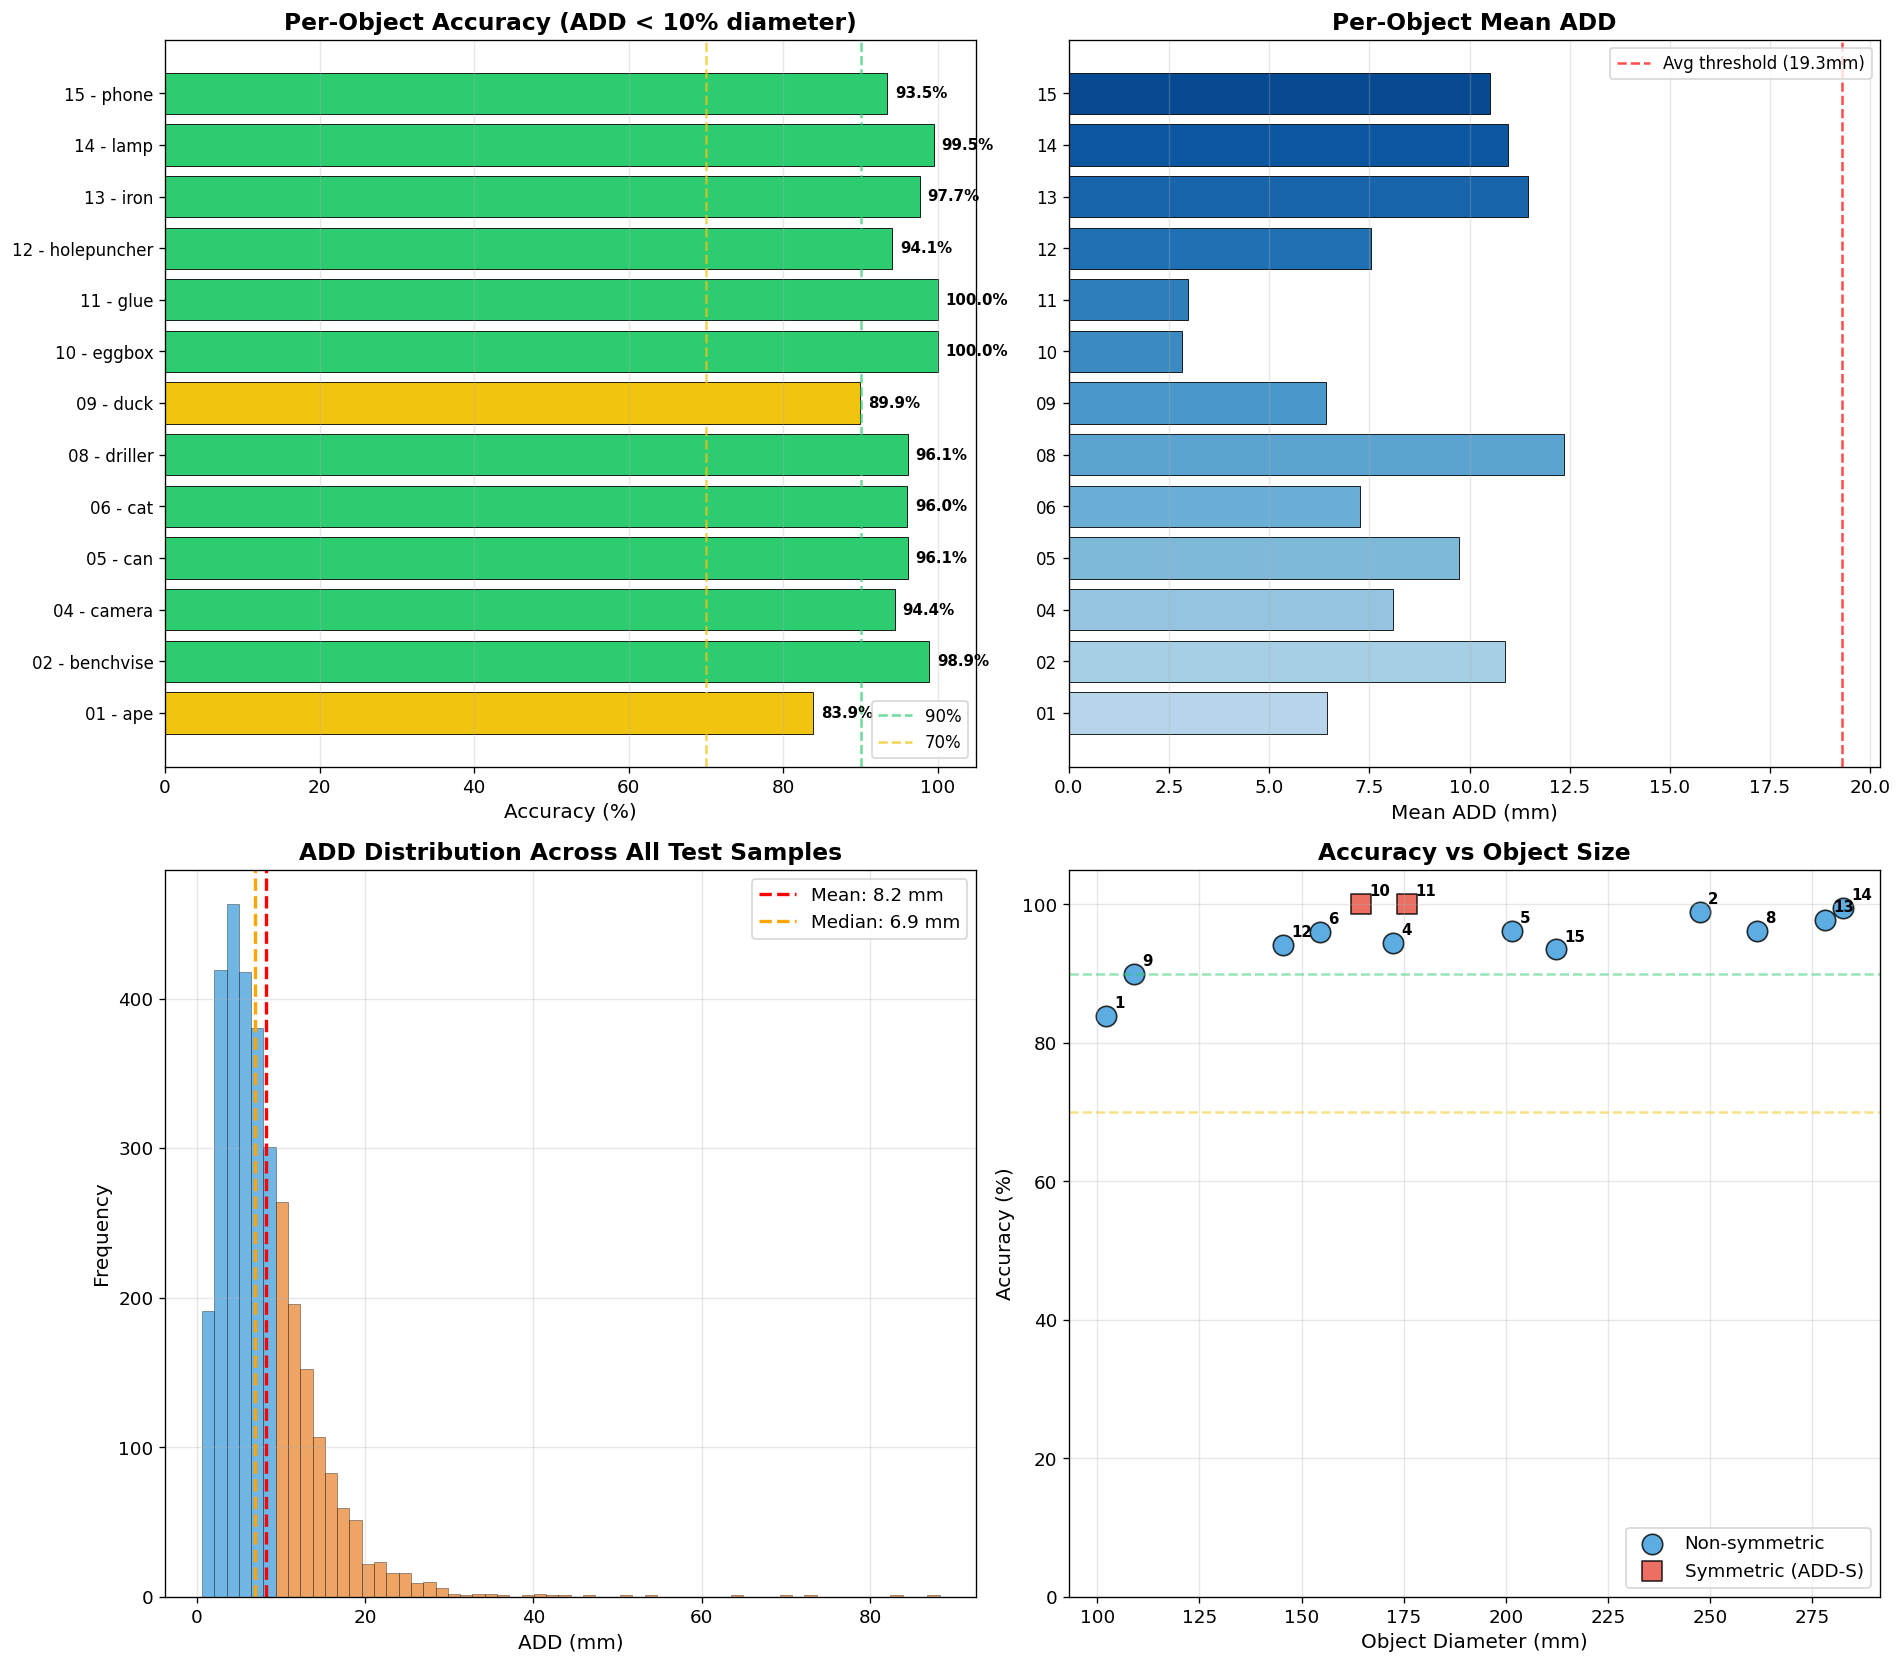

✅ Figure saved: per_object_analysis.png


In [17]:
# ============================================================================
# 7.1 Per-Object Performance Visualization
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Sort for consistent plotting
df_plot = df_results.sort_index()

# Color scheme
colors_acc = ['#2ecc71' if acc >= 90 else '#f1c40f' if acc >= 70 else '#e74c3c' 
              for acc in df_plot['Accuracy (%)']]

# 1. Accuracy by Object (Horizontal Bar)
ax1 = axes[0, 0]
y_pos = np.arange(len(df_plot))
bars = ax1.barh(y_pos, df_plot['Accuracy (%)'], color=colors_acc, edgecolor='black', linewidth=0.5)
ax1.set_yticks(y_pos)
ax1.set_yticklabels([f"{idx:02d} - {row['Object']}" for idx, row in df_plot.iterrows()], fontsize=10)
ax1.set_xlabel('Accuracy (%)', fontsize=12)
ax1.set_title('Per-Object Accuracy (ADD < 10% diameter)', fontsize=14, fontweight='bold')
ax1.axvline(x=90, color='#2ecc71', linestyle='--', alpha=0.7, linewidth=1.5, label='90%')
ax1.axvline(x=70, color='#f1c40f', linestyle='--', alpha=0.7, linewidth=1.5, label='70%')
ax1.set_xlim(0, 105)
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, df_plot['Accuracy (%)'])):
    ax1.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
             va='center', ha='left', fontsize=9, fontweight='bold')

# 2. Mean ADD by Object
ax2 = axes[0, 1]
colors_add = plt.cm.Blues(np.linspace(0.3, 0.9, len(df_plot)))
bars2 = ax2.barh(y_pos, df_plot['Mean ADD (mm)'], color=colors_add, edgecolor='black', linewidth=0.5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([f"{idx:02d}" for idx in df_plot.index], fontsize=10)
ax2.set_xlabel('Mean ADD (mm)', fontsize=12)
ax2.set_title('Per-Object Mean ADD', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Add threshold line (10% of average diameter)
avg_thresh = np.mean([models_info[oid]['diameter'] * 0.1 for oid in df_plot.index])
ax2.axvline(x=avg_thresh, color='red', linestyle='--', alpha=0.7, linewidth=1.5, 
            label=f'Avg threshold ({avg_thresh:.1f}mm)')
ax2.legend(loc='upper right', fontsize=10)

# 3. ADD Distribution (Histogram)
ax3 = axes[1, 0]
add_array = np.array(results['add_values'])
n, bins, patches = ax3.hist(add_array, bins=60, color='steelblue', alpha=0.7, 
                            edgecolor='black', linewidth=0.3)

# Color bins by threshold
for i, patch in enumerate(patches):
    if bins[i] < results['mean_add']:
        patch.set_facecolor('#3498db')
    else:
        patch.set_facecolor('#e67e22')

ax3.axvline(x=results['mean_add'], color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {results["mean_add"]:.1f} mm')
ax3.axvline(x=np.median(add_array), color='orange', linestyle='--', linewidth=2,
            label=f'Median: {np.median(add_array):.1f} mm')
ax3.set_xlabel('ADD (mm)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('ADD Distribution Across All Test Samples', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right', fontsize=11)
ax3.grid(True, alpha=0.3)

# 4. Accuracy vs Object Size
ax4 = axes[1, 1]
symmetric_mask = df_plot['Symmetric'] == '✓'

# Non-symmetric objects
ax4.scatter(df_plot.loc[~symmetric_mask, 'Diameter (mm)'], 
           df_plot.loc[~symmetric_mask, 'Accuracy (%)'],
           c='#3498db', s=150, alpha=0.8, edgecolors='black', linewidth=1, 
           label='Non-symmetric', marker='o')

# Symmetric objects
ax4.scatter(df_plot.loc[symmetric_mask, 'Diameter (mm)'], 
           df_plot.loc[symmetric_mask, 'Accuracy (%)'],
           c='#e74c3c', s=150, alpha=0.8, edgecolors='black', linewidth=1,
           label='Symmetric (ADD-S)', marker='s')

# Annotate points
for idx, row in df_plot.iterrows():
    ax4.annotate(f'{idx}', (row['Diameter (mm)'], row['Accuracy (%)']),
                xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

ax4.set_xlabel('Object Diameter (mm)', fontsize=12)
ax4.set_ylabel('Accuracy (%)', fontsize=12)
ax4.set_title('Accuracy vs Object Size', fontsize=14, fontweight='bold')
ax4.axhline(y=90, color='#2ecc71', linestyle='--', alpha=0.5, linewidth=1.5)
ax4.axhline(y=70, color='#f1c40f', linestyle='--', alpha=0.5, linewidth=1.5)
ax4.legend(loc='lower right', fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 105)

plt.tight_layout()
plt.savefig(IMG_EXPORT_REL + 'per_object_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Figure saved: per_object_analysis.png")

In [18]:
# ============================================================================
# 7.2 Rotation and Translation Error Analysis
# ============================================================================
# Compute rotation errors (in degrees)
rotation_errors = []

for i in range(len(all_pred_R)):
    # Compute relative rotation: R_error = R_pred^T @ R_gt
    R_error = all_pred_R[i].T @ all_gt_R[i]
    R_error_np = R_error.cpu().numpy()
    
    # Convert to angle-axis and extract angle
    r = R_scipy.from_matrix(R_error_np)
    angle = np.linalg.norm(r.as_rotvec())  # radians
    angle_deg = np.degrees(angle)
    rotation_errors.append(angle_deg)

rotation_errors = np.array(rotation_errors)

# Compute translation errors (in mm)
translation_errors = torch.norm(all_pred_t - all_gt_t, dim=1).cpu().numpy() * 1000

print(f"🔄 Rotation Errors:")
print(f"   Mean: {rotation_errors.mean():.2f}°")
print(f"   Median: {np.median(rotation_errors):.2f}°")
print(f"   Std: {rotation_errors.std():.2f}°")

print(f"\n📏 Translation Errors:")
print(f"   Mean: {translation_errors.mean():.2f} mm")
print(f"   Median: {np.median(translation_errors):.2f} mm")
print(f"   Std: {translation_errors.std():.2f} mm")

🔄 Rotation Errors:
   Mean: 10.42°
   Median: 8.93°
   Std: 7.65°

📏 Translation Errors:
   Mean: 30.88 mm
   Median: 27.37 mm
   Std: 17.41 mm


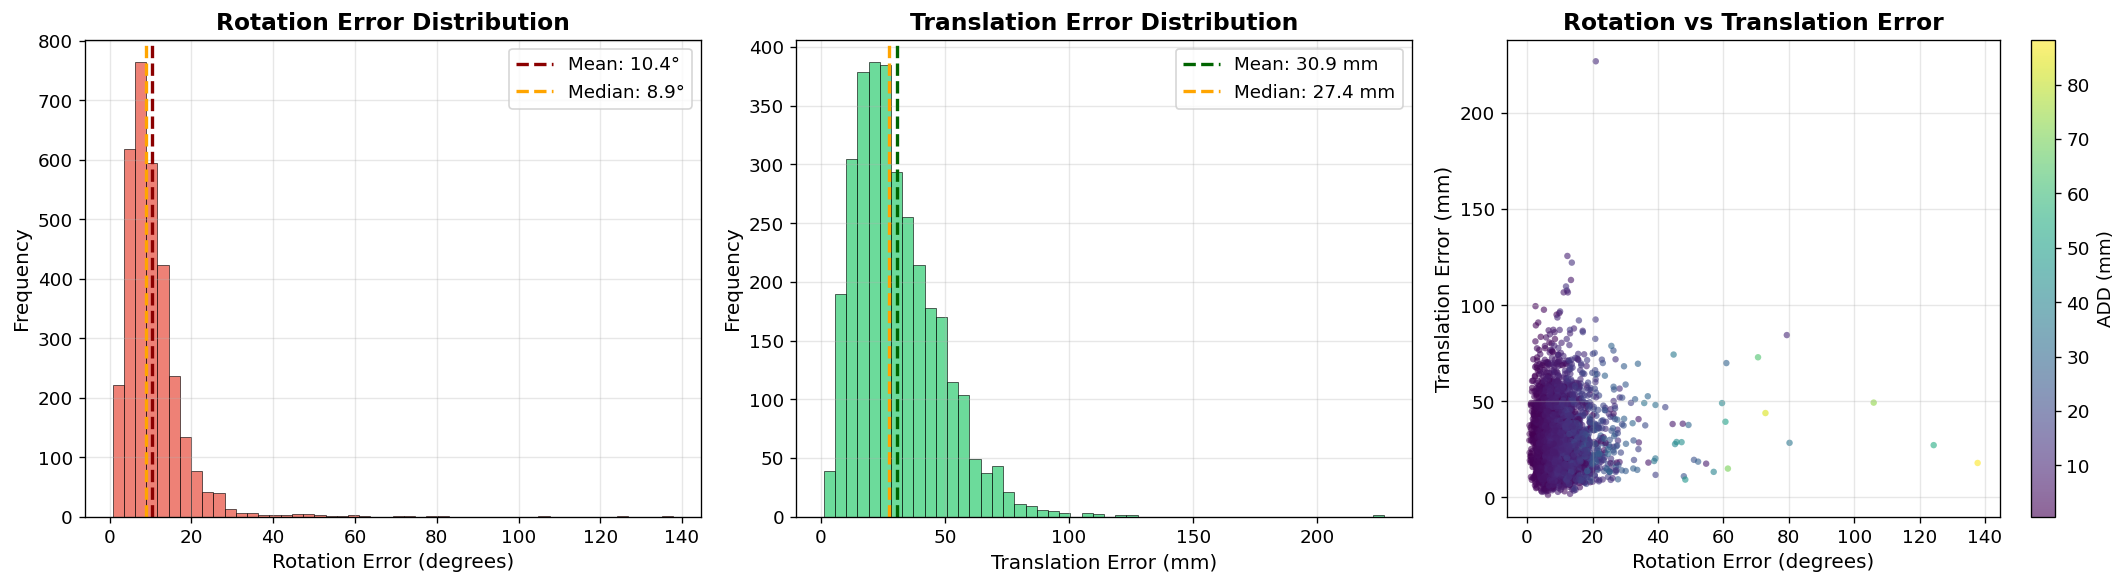

✅ Figure saved: error_distributions.png


In [19]:
# ============================================================================
# 7.3 Error Distribution Visualization
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Rotation error distribution
ax1 = axes[0]
ax1.hist(rotation_errors, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.axvline(x=rotation_errors.mean(), color='darkred', linestyle='--', linewidth=2,
           label=f'Mean: {rotation_errors.mean():.1f}°')
ax1.axvline(x=np.median(rotation_errors), color='orange', linestyle='--', linewidth=2,
           label=f'Median: {np.median(rotation_errors):.1f}°')
ax1.set_xlabel('Rotation Error (degrees)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Rotation Error Distribution', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Translation error distribution
ax2 = axes[1]
ax2.hist(translation_errors, bins=50, color='#2ecc71', alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.axvline(x=translation_errors.mean(), color='darkgreen', linestyle='--', linewidth=2,
           label=f'Mean: {translation_errors.mean():.1f} mm')
ax2.axvline(x=np.median(translation_errors), color='orange', linestyle='--', linewidth=2,
           label=f'Median: {np.median(translation_errors):.1f} mm')
ax2.set_xlabel('Translation Error (mm)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Translation Error Distribution', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=11)
ax2.grid(True, alpha=0.3)

# 3. Rotation vs Translation scatter (colored by ADD)
ax3 = axes[2]
scatter = ax3.scatter(rotation_errors, translation_errors, 
                     c=np.array(results['add_values']), cmap='viridis', 
                     alpha=0.6, s=15, edgecolors='none')
ax3.set_xlabel('Rotation Error (degrees)', fontsize=12)
ax3.set_ylabel('Translation Error (mm)', fontsize=12)
ax3.set_title('Rotation vs Translation Error', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('ADD (mm)', fontsize=11)

plt.tight_layout()
plt.savefig(IMG_EXPORT_REL + 'error_distributions.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Figure saved: error_distributions.png")


Accuracy at Different ADD Thresholds:
----------------------------------------
     2.0% diameter:  18.43%
     5.0% diameter:  66.92%
    10.0% diameter:  95.10%
    15.0% diameter:  99.03%
    20.0% diameter:  99.56%


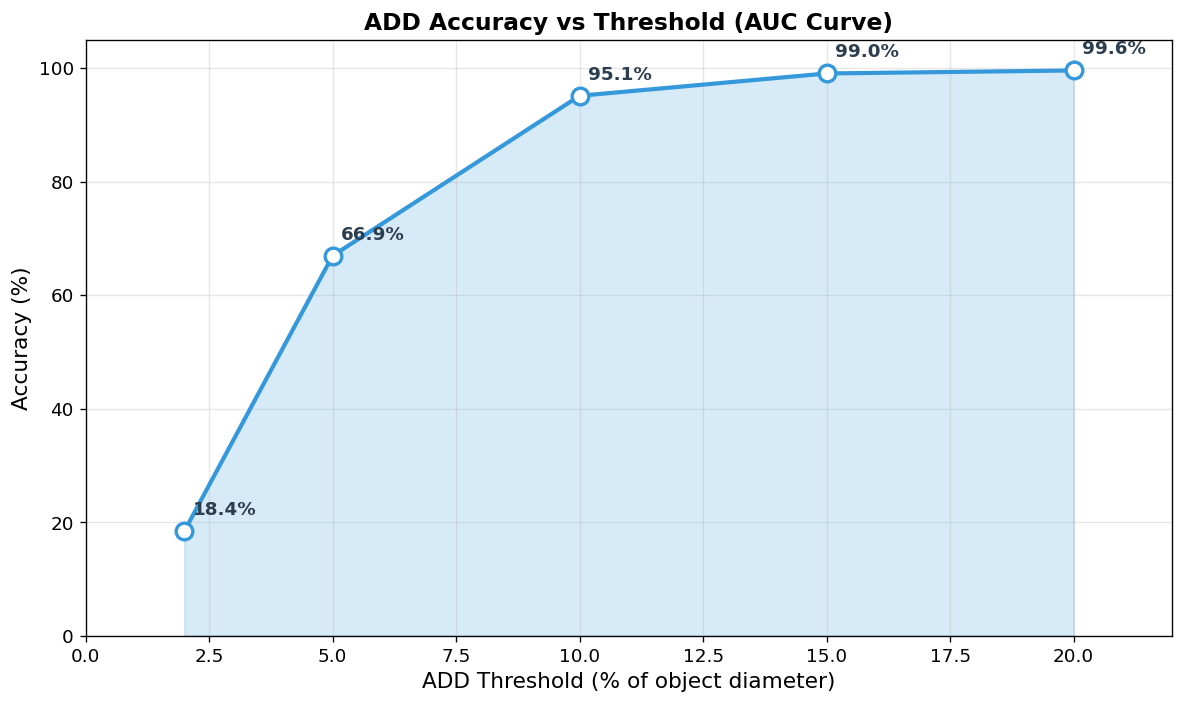

Figure saved: accuracy_vs_threshold.png


In [21]:
# ============================================================================
# 7.4 Accuracy at Different Thresholds (for Paper)
# ============================================================================
thresholds = [0.02, 0.05, 0.10, 0.15, 0.20]
threshold_accuracies = []

print(f"\nAccuracy at Different ADD Thresholds:")
print("-" * 40)

for thresh in thresholds:
    results_thresh = compute_add_batch_full_pose(
        pred_R_batch=all_pred_R,
        pred_t_batch=all_pred_t,
        gt_R_batch=all_gt_R,
        gt_t_batch=all_gt_t,
        obj_ids=all_obj_ids,
        models_dict=models_dict,
        models_info=models_info,
        symmetric_objects=Config.SYMMETRIC_OBJECTS,
        threshold=thresh
    )
    acc = results_thresh['accuracy'] * 100
    threshold_accuracies.append(acc)
    print(f"   {thresh*100:5.1f}% diameter: {acc:6.2f}%")

# Plot accuracy curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot([t*100 for t in thresholds], threshold_accuracies, 'o-', 
        color='#3498db', linewidth=2.5, markersize=10, markerfacecolor='white', 
        markeredgecolor='#3498db', markeredgewidth=2)

ax.fill_between([t*100 for t in thresholds], threshold_accuracies, alpha=0.2, color='#3498db')

ax.set_xlabel('ADD Threshold (% of object diameter)', fontsize=13)
ax.set_ylabel('Accuracy (%)', fontsize=13)
ax.set_title('ADD Accuracy vs Threshold (AUC Curve)', fontsize=14, fontweight='bold')
ax.set_xlim(0, 22)
ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3)

# Add data labels
for t, acc in zip(thresholds, threshold_accuracies):
    ax.annotate(f'{acc:.1f}%', (t*100, acc), 
                xytext=(5, 10), textcoords='offset points',
                fontsize=11, fontweight='bold', color='#2c3e50')

plt.tight_layout()
plt.savefig(IMG_EXPORT_REL + 'accuracy_vs_threshold.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved: accuracy_vs_threshold.png")

## 8. Qualitative Results: Best and Worst Predictions

/var/folders/50/45169f_s0b97n3l9tzd7rlp00000gn/T/ipykernel_80491/921570789.py:53: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/50/45169f_s0b97n3l9tzd7rlp00000gn/T/ipykernel_80491/921570789.py:54: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(IMG_EXPORT_REL + 'best_predictions_yolo.png', dpi=150, bbox_inches='tight', facecolor='white')
/Users/ale/Documents/polito/AML/polito-aml-6D-pose-estimation/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


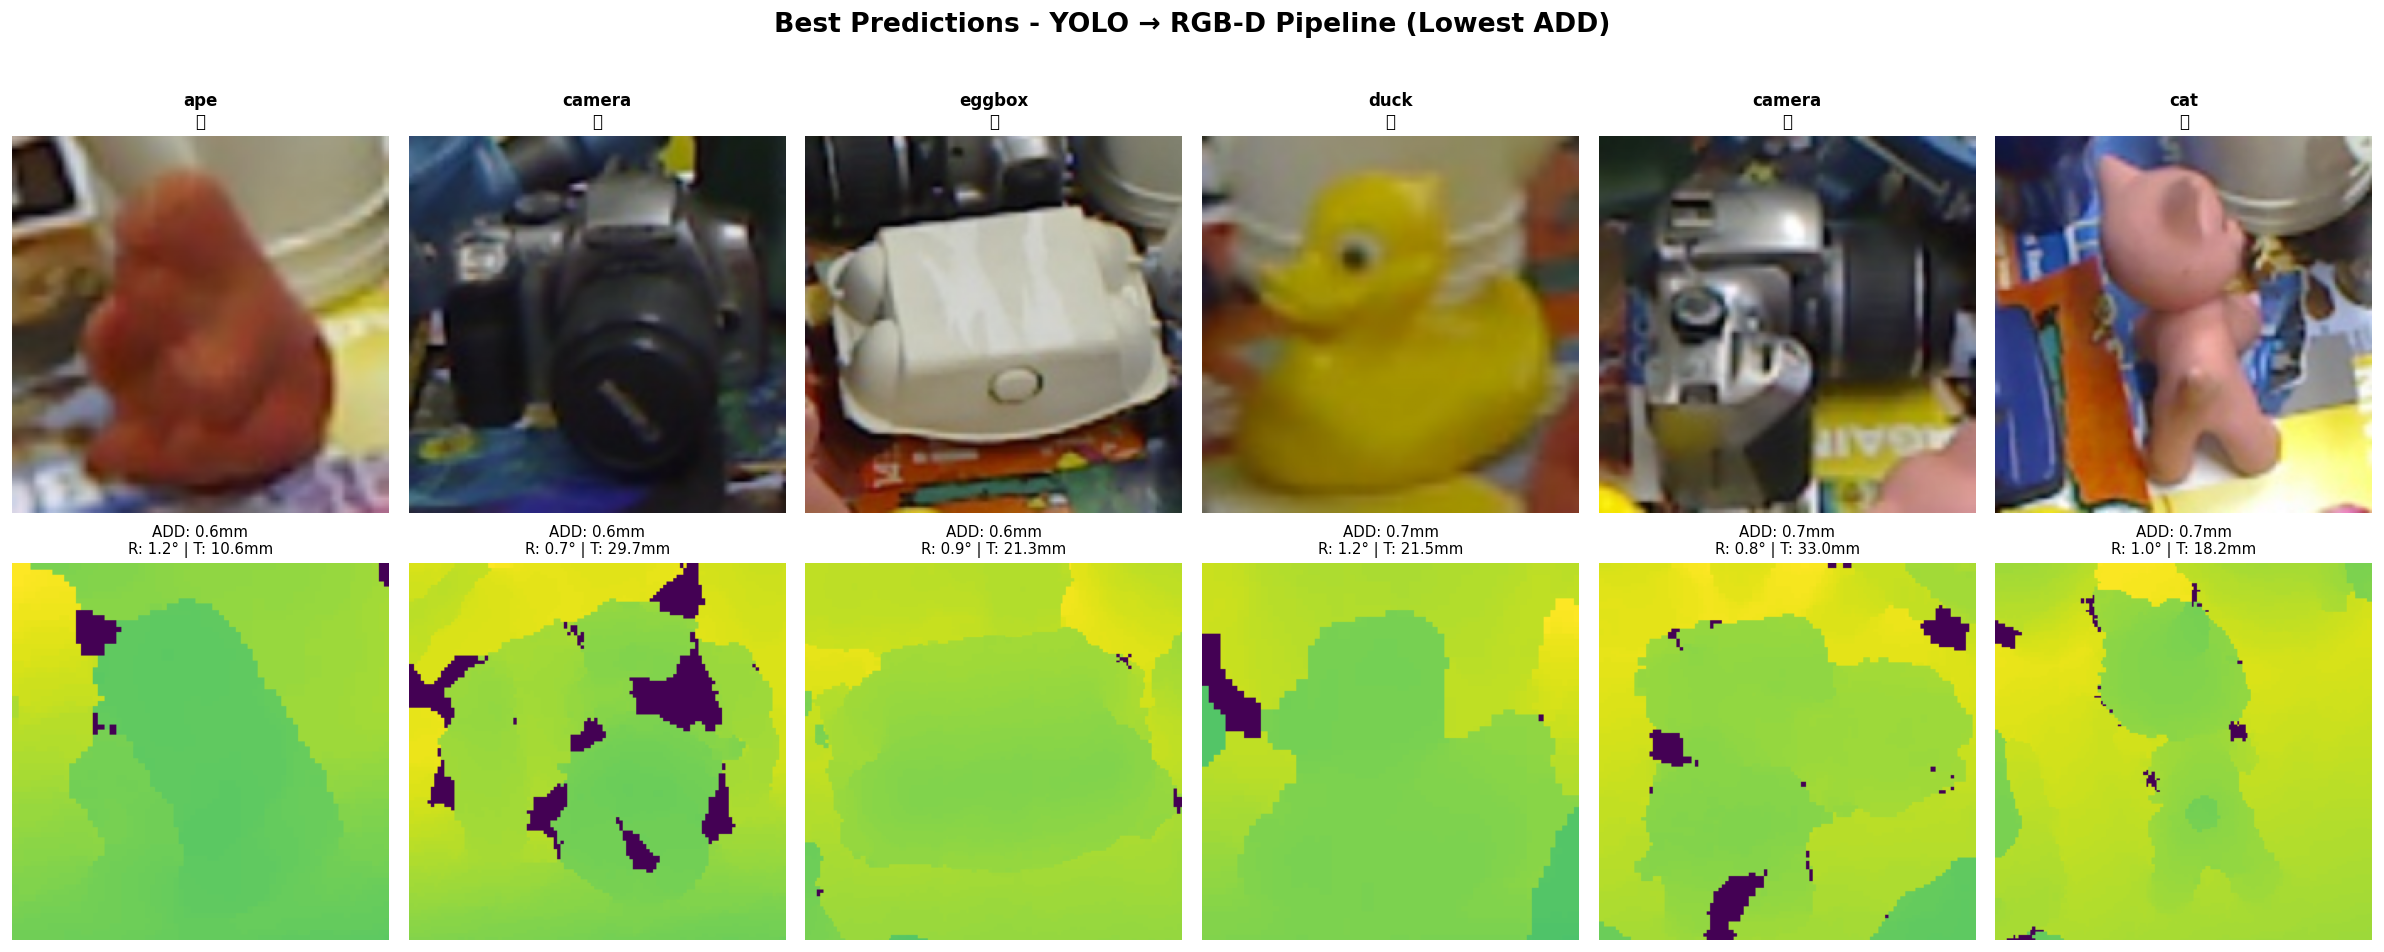

/var/folders/50/45169f_s0b97n3l9tzd7rlp00000gn/T/ipykernel_80491/921570789.py:75: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/50/45169f_s0b97n3l9tzd7rlp00000gn/T/ipykernel_80491/921570789.py:76: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(IMG_EXPORT_REL + 'worst_predictions_yolo.png', dpi=150, bbox_inches='tight', facecolor='white')
/Users/ale/Documents/polito/AML/polito-aml-6D-pose-estimation/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


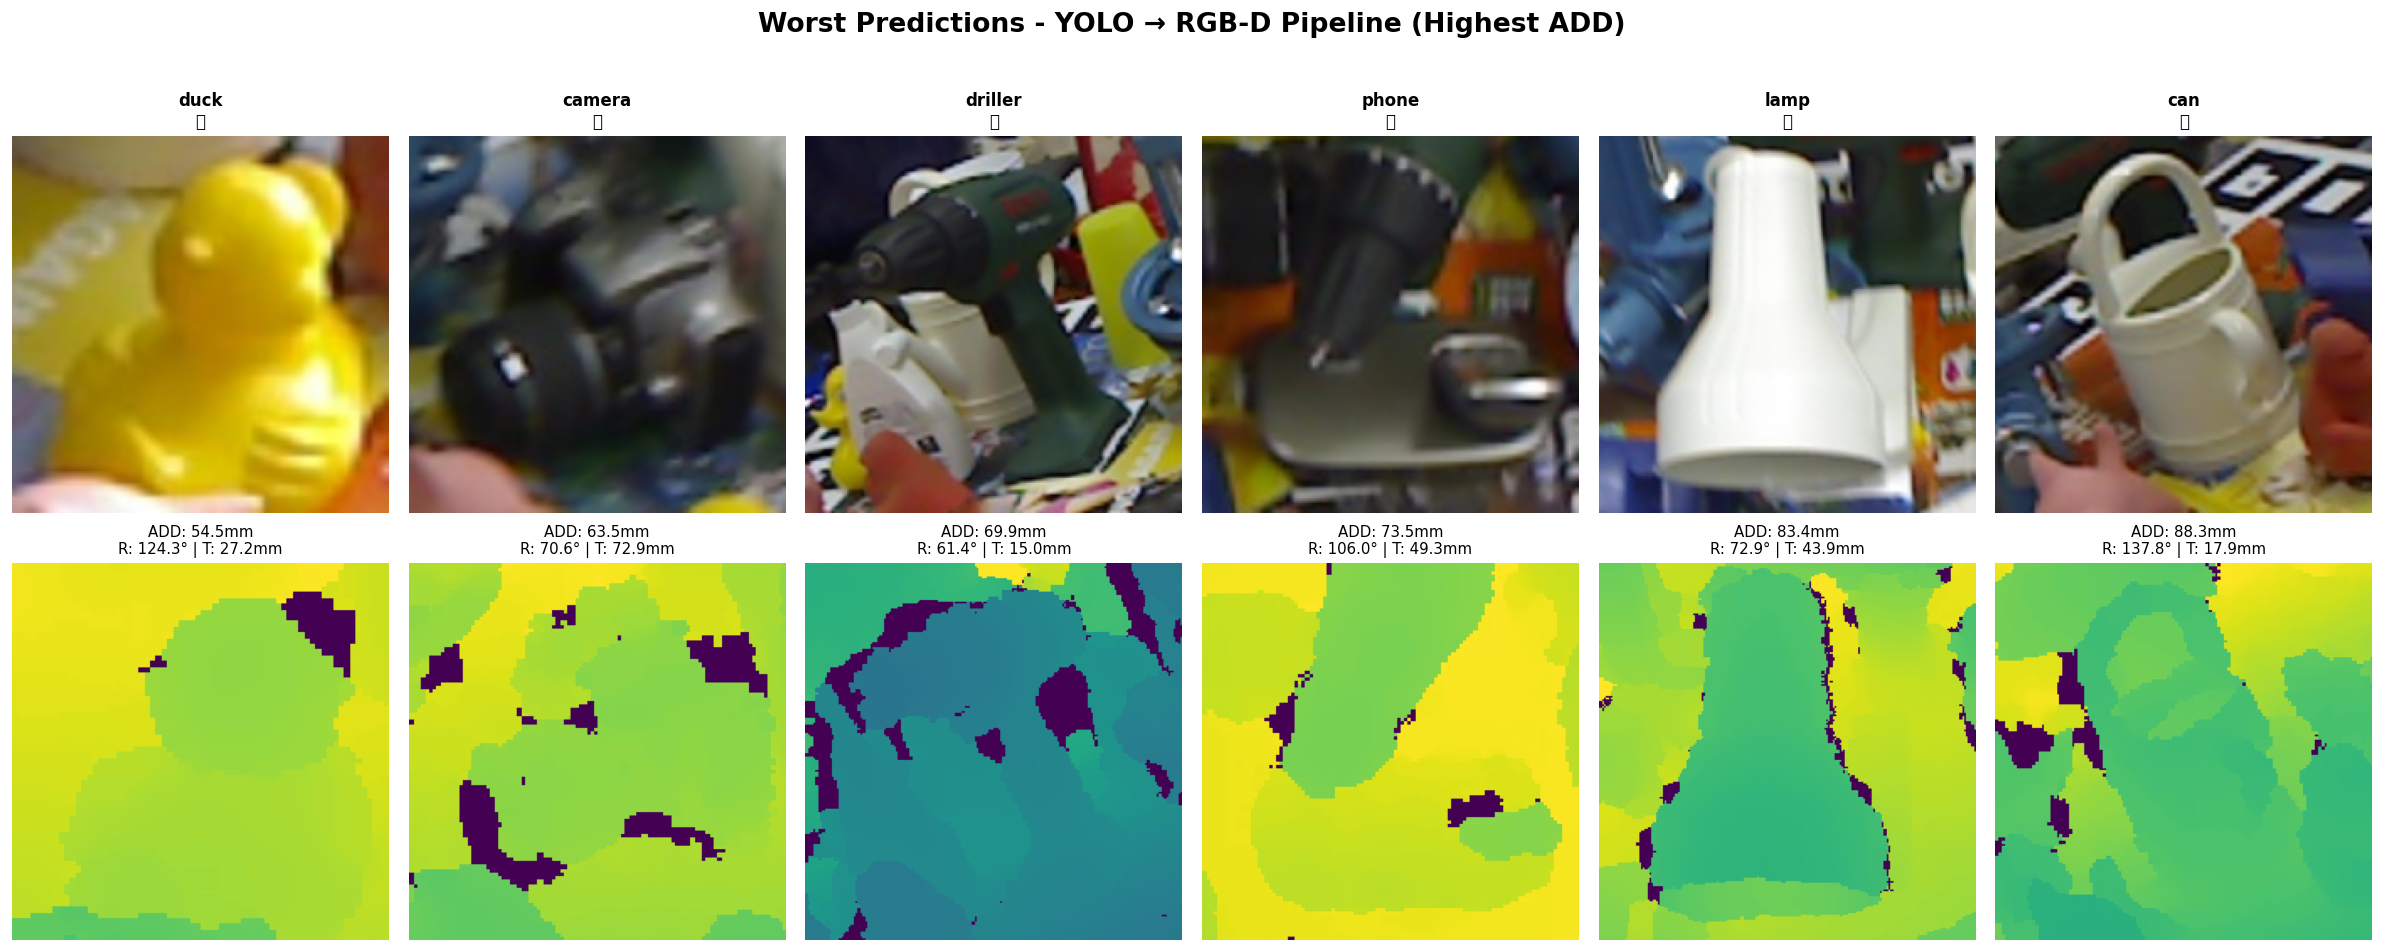

✅ Figures saved: best_predictions_yolo.png, worst_predictions_yolo.png


In [22]:
# ============================================================================
# 8.1 Visualize Best and Worst Predictions (from YOLO Pipeline)
# ============================================================================
add_array = np.array(results['add_values'])
best_indices = np.argsort(add_array)[:6]   # Top 6 best
worst_indices = np.argsort(add_array)[-6:]  # Top 6 worst

def get_sample_info_yolo(idx):
    """Get info for visualization using YOLO pipeline results."""
    obj_id = all_obj_ids[idx]
    obj_name = Config.LINEMOD_OBJECTS.get(obj_id, {}).get('name', f'Obj {obj_id}')
    add_value = results['add_values'][idx]
    is_correct = results['is_correct'][idx]
    status = "✅" if is_correct else "❌"
    
    # Use stored crops from YOLO pipeline (NOT from dataset with GT bbox)
    rgb_crop = all_rgb_crops[idx]  # Already in RGB format, 0-255
    depth_crop = all_depth_crops[idx]  # Already normalized 0-1
    
    # Normalize RGB for display
    rgb_display = rgb_crop / 255.0
    
    return {
        'rgb': rgb_display,
        'depth': depth_crop,
        'obj_id': obj_id,
        'obj_name': obj_name,
        'add': add_value,
        'status': status,
        'rot_err': rotation_errors[idx],
        'trans_err': translation_errors[idx],
        'original_idx': all_original_indices[idx]
    }

# Best predictions
fig, axes = plt.subplots(2, 6, figsize=(20, 8))
fig.suptitle('Best Predictions - YOLO → RGB-D Pipeline (Lowest ADD)', fontsize=16, fontweight='bold', y=1.02)

for i, idx in enumerate(best_indices):
    info = get_sample_info_yolo(idx)
    
    # RGB (cropped by YOLO bbox)
    axes[0, i].imshow(info['rgb'])
    axes[0, i].set_title(f"{info['obj_name']}\n{info['status']}", fontsize=10, fontweight='bold')
    axes[0, i].axis('off')
    
    # Depth with metrics
    axes[1, i].imshow(info['depth'], cmap='viridis')
    axes[1, i].set_title(f"ADD: {info['add']:.1f}mm\nR: {info['rot_err']:.1f}° | T: {info['trans_err']:.1f}mm", 
                        fontsize=9)
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(IMG_EXPORT_REL + 'best_predictions_yolo.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Worst predictions  
fig, axes = plt.subplots(2, 6, figsize=(20, 8))
fig.suptitle('Worst Predictions - YOLO → RGB-D Pipeline (Highest ADD)', fontsize=16, fontweight='bold', y=1.02)

for i, idx in enumerate(worst_indices):
    info = get_sample_info_yolo(idx)
    
    # RGB (cropped by YOLO bbox)
    axes[0, i].imshow(info['rgb'])
    axes[0, i].set_title(f"{info['obj_name']}\n{info['status']}", fontsize=10, fontweight='bold')
    axes[0, i].axis('off')
    
    # Depth with metrics
    axes[1, i].imshow(info['depth'], cmap='viridis')
    axes[1, i].set_title(f"ADD: {info['add']:.1f}mm\nR: {info['rot_err']:.1f}° | T: {info['trans_err']:.1f}mm", 
                        fontsize=9)
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(IMG_EXPORT_REL + 'worst_predictions_yolo.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Figures saved: best_predictions_yolo.png, worst_predictions_yolo.png")

## 9. Summary

Final summary of all metrics in a publication-ready format.

In [37]:
# ============================================================================
# 9.1 Final Summary Table (YOLO → RGB-D Pipeline)
# ============================================================================
params = rgbd_model.count_parameters()

# Compute effective accuracy (YOLO misses count as failures)
effective_correct = sum(results['is_correct'])
effective_total = len(test_base)
effective_accuracy = effective_correct / effective_total * 100

summary_data = {
    'Metric': [
        '=== YOLO Detection ===',
        'YOLO Detection Rate',
        'YOLO Misses',
        '=== Pose Accuracy (evaluated samples) ===',
        'Pose Accuracy (10% diameter)',
        'Pose Accuracy (5% diameter)',
        'Pose Accuracy (2% diameter)',
        '=== Effective Accuracy (all samples) ===',
        'Effective Accuracy (incl. YOLO misses)',
        '=== Pose Errors ===',
        'Mean ADD (mm)',
        'Median ADD (mm)',
        'Mean Rotation Error (°)',
        'Median Rotation Error (°)',
        'Mean Translation Error (mm)',
        'Median Translation Error (mm)',
        '=== Dataset Info ===',
        'Total Test Samples',
        'Evaluated Samples',
        'Number of Objects',
        '=== Model Info ===',
        'Model Parameters',
        'Trainable Parameters'
    ],
    'Value': [
        '',
        f"{100*yolo_detections_count/len(test_base):.2f}%",
        f"{yolo_misses_count} ({100*yolo_misses_count/len(test_base):.2f}%)",
        '',
        f"{results['accuracy']*100:.2f}%",
        f"{threshold_accuracies[1]:.2f}%",
        f"{threshold_accuracies[0]:.2f}%",
        '',
        f"{effective_accuracy:.2f}%",
        '',
        f"{results['mean_add']:.2f}",
        f"{np.median(results['add_values']):.2f}",
        f"{rotation_errors.mean():.2f}",
        f"{np.median(rotation_errors):.2f}",
        f"{translation_errors.mean():.2f}",
        f"{np.median(translation_errors):.2f}",
        '',
        f"{len(test_base):,}",
        f"{len(results['add_values']):,}",
        f"{len(set(all_obj_ids))}",
        '',
        f"{params['total']:,}",
        f"{params['trainable']:,}"
    ]
}

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*70)
print(f"{'YOLO → RGB-D FUSION PIPELINE - FULL RESULTS':^70}")
print("="*70)
display(df_summary.style.hide(axis='index'))
print("="*70)

# Save to CSV for paper
df_summary.to_csv('rgbd_pipeline_results.csv', index=False)
print("\nResults saved to: rgbd_pipeline_results.csv")


             YOLO → RGB-D FUSION PIPELINE - FULL RESULTS              



Results saved to: rgbd_pipeline_results.csv


### Per object results

In [39]:
# ============================================================================
# 9.2 Per-Object Results Table (for paper appendix)
# ============================================================================
# Create publication-ready per-object table
df_paper = df_results[['Object', 'Count', 'Mean ADD (mm)', 'Accuracy (%)', 'Diameter (mm)', 'Symmetric']].copy()
df_paper.columns = ['Object', 'Samples', 'ADD (mm)', 'Acc. (%)', 'Diam. (mm)', 'Sym.']
df_paper['ADD (mm)'] = df_paper['ADD (mm)'].apply(lambda x: f'{x:.1f}')
df_paper['Acc. (%)'] = df_paper['Acc. (%)'].apply(lambda x: f'{x:.1f}')
df_paper['Diam. (mm)'] = df_paper['Diam. (mm)'].apply(lambda x: f'{x:.0f}')

print("\nPer-Object Results (for Paper):")
print("-" * 70)
display(df_paper)
print("-" * 70)

# Save to CSV
df_paper.to_csv('per_object_results.csv')
print("\nPer-object results saved to: per_object_results.csv")


Per-Object Results (for Paper):
----------------------------------------------------------------------


Object  Samples ADD (mm) Acc. (%) Diam. (mm) Sym.
ID                                                        
10       eggbox      188      2.8    100.0        165    ✓
11         glue      181      3.0    100.0        176    ✓
14         lamp      185     11.0     99.5        283     
2     benchvise      181     10.9     98.9        248     
13         iron      173     11.4     97.7        278     
5           can      180      9.7     96.1        201     
8       driller      179     12.4     96.1        261     
6           cat      177      7.3     96.0        155     
4        camera     1018      8.1     94.4        172     
12  holepuncher      186      7.5     94.1        146     
15        phone      184     10.5     93.5        212     
9          duck      189      6.4     89.9        109     
1           ape      186      6.4     83.9        102

----------------------------------------------------------------------

Per-object results saved to: per_object_results.csv


## 10. Conclusion

### Pipeline Summary

The **YOLO → RGB-D Fusion** pipeline demonstrates effective end-to-end 6D pose estimation:


### Key Pipeline Steps (VALIDATED)

1. **YOLO11 Detection**: Fine-tuned on LineMOD, outputs bounding boxes per object
2. **ROI Cropping**: Uses **YOLO bboxes** to crop RGB and Depth at same coordinates
3. **RGB-D Fusion Model**:
   - RGB features (ResNet-18): 512-dim
   - Depth features (DepthEncoder): 512-dim  
   - Meta features (bbox + intrinsics): 32-dim → disambiguates translation
4. **Pose Regressor**: Outputs 7-dim pose `[qw, qx, qy, qz, tx, ty, tz]`

### Important Notes

⚠️ **This evaluation uses YOLO detections**, not ground truth bboxes:
- Samples where YOLO fails to detect are **excluded** from pose metrics
- "Effective Accuracy" includes YOLO misses as failures for fair comparison
- Bbox quality from YOLO directly impacts pose estimation accuracy


### References

- Wang et al., "DenseFusion: 6D Object Pose Estimation by Iterative Dense Fusion", CVPR 2019
- Hinterstoisser et al., "Model Based Training, Detection and Pose Estimation of Texture-Less 3D Objects in Heavily Cluttered Scenes", ACCV 2012